In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import networkx as nx

In [3]:
import heapq

In [19]:
from create_graph.create_graph import generate_distances
NUM_SHOWERS_IN_BRICK = 200

In [5]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output
import sys
sys.path.append("..")
from opera_tools import plot_graphx, DISTANCE, scattering_estimation_loss
from sklearn.linear_model import TheilSenRegressor
from copy import deepcopy      
from collections import Counter

process = psutil.Process(os.getpid())

In [6]:
from functools import total_ordering

@total_ordering
class ClusterHDBSCAN(object):
    def __init__(self, weight: float, cl_size: int, clusters: list = None, nodes: list = None):
        # init
        self.nodes = set()
        self.nodes_in = Counter()
        self.nodes_out = Counter()
        
        self.weights_nodes_dict = defaultdict(set)
        
        self.weight_death = weight
        self.lambda_death = 1. / (weight + 1e-5)
        
        self.weight_birth = weight
        self.lambda_birth = 1. / (weight + 1e-5)
        
        
        self.children = []
        self.falling_out_points = []
        
        assert clusters is not None or nodes is not None
        if clusters is not None:
            for cluster in clusters:
                self.nodes.update(cluster.nodes)
                self.nodes_in.update(cluster.nodes_in)
                self.nodes_out.update(cluster.nodes_out)
                self.weights_nodes_dict[weight].update(cluster.nodes)
                if cluster.is_cluster:
                    cluster.set_weight_birth(weight)
                    self.children.append(cluster)
                else:
                    self.falling_out_points.append(cluster)
        else:
            self.nodes.update(nodes)
            self.nodes_out.update(nodes)
            self.weights_nodes_dict[weight].update(nodes)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.cl_size = cl_size
        self.is_cluster = len(self) >= cl_size
        self.is_noise = not self.is_cluster
        self.stability = None
        
        
    def append(self, weight: float, clusters: list):
        """
        Adding
        """
        for cluster in clusters:
            self.nodes.update(cluster.nodes)
            self.weights_nodes_dict[weight].update(cluster.nodes)
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.is_cluster = len(self) >= self.cl_size
        self.is_noise = not self.is_cluster
        return self
    
    def __iter__(self):
        for child in self.children:
            yield child
    
    def __contains__(self, node):
        return node in self.nodes
    
    def __len__(self):
        return len(self.nodes)
    
    def __hash__(self):
        return self.__hash
    
    def __eq__(self, other):
        return self.__hash == other.__hash

    def __lt__(self, other):
        return self.__hash < other.__hash
    
    def set_weight_birth(self, weight: float):
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        
    def calculate_stability(self):
        self.stability = 0.
        self.lambda_birth = 1 / (max(self.weights_nodes_dict.keys()) + 1e-5)
        norm = self.lambda_birth
        for weight in self.weights_nodes_dict:
            self.stability += len(self.weights_nodes_dict[weight]) * (1 / (weight + 1e-5) - self.lambda_birth) * norm
            
def calc_stabilities(root):
    root.calculate_stability()
    for child in root:
        calc_stabilities(child)
        
        
def class_disbalance(cluster, graph):
    subgraph = graph.subgraph(cluster.nodes)
    signal = []
    for _, node in subgraph.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def flat_clusters(root):
    if root.is_cluster:
        yield root
        
    for child in root:
        for cluster in flat_clusters(child):
            yield cluster
            
def reed_stabilities(root, level=0):
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)), end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        reed_stabilities(child, level + 1)

def print_class_disbalance_for_all_clusters(root, graph, level=0):
    class_disbalance_tuples = class_disbalance(root, graph)

    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples, end=' ')
    print('stability={:.3f}'.format(root.stability))
    for child in root:
        print_class_disbalance_for_all_clusters(child, graph, level + 1)
        
def leaf_clusters(root):
    if root.is_cluster and len(root.children) == 0:
        yield root
        
    for child in root:
        for cluster in leaf_clusters(child):
            yield cluster

def max_level_clusters(root, level=0, max_level=2):
    if level == max_level and root.is_cluster:
        yield root
        
    for child in root:
        for cluster in max_level_clusters(child, level=level+1, max_level=max_level):
            yield cluster
            
            
def recalc_tree(root):
    weights_children = 0
    for child in root:
        weights_children += recalc_tree(child)
    if weights_children > root.stability:
        root.stability = weights_children
    else:
        root.children.clear()
    
    return root.stability


In [7]:
from math import fabs, sqrt, log
def rms_integral_root_closed_py(basetrack_left, basetrack_right):
    EPS = 1e-6
    dz = basetrack_right['features']['SZ'] - basetrack_left['features']['SZ']
    dx = basetrack_left['features']['SX'] - (basetrack_right['features']['SX'] - basetrack_right['features']['TX'] * dz)
    dy = basetrack_left['features']['SY'] - (basetrack_right['features']['SY'] - basetrack_right['features']['TY'] * dz)
    dtx = (basetrack_left['features']['TX'] - basetrack_right['features']['TX'])
    dty = (basetrack_left['features']['TY'] - basetrack_right['features']['TY'])
    
    a = (dtx * dz) ** 2 + (dty * dz) ** 2
    b = 2 * (dtx * dz * dx +  dty * dz * dy)
    c = dx ** 2 + dy ** 2
    if a == 0.:
        return fabs(sqrt(c))
    discriminant = (b ** 2 - 4 * a * c)
    log_denominator = 2 * sqrt(a) * sqrt(a + b + c) + 2 * a + b + EPS
    log_numerator = 2 * sqrt(a) * sqrt(c) + b + EPS
    first_part = ( (2 * a + b) * sqrt(a + b + c) - b * sqrt(c) ) / (4 * a)
    
    if fabs(discriminant) < EPS:
        return fabs(first_part)
    else: 
        result = fabs((discriminant * log(log_numerator / log_denominator) / (8 * sqrt(a * a * a)) + first_part))
        return result


def class_disbalance_graphx(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def class_disbalance_graphx__(graphx):
    signal = []
    for _, node in graphx.nodes(data=True):
        signal.append(node['signal'])
    return np.unique(signal, return_counts=True)

In [8]:
from math import sqrt
from sklearn.linear_model import TheilSenRegressor, LinearRegression, HuberRegressor

def estimate_params(cluster, angle=0.03):
    x, y, z = estimate_start_xyz(cluster)
    tx, ty = estimate_txty(cluster)
    n = 0
    for i, node in cluster.nodes(data=True):
        #print(x, node['features']['SX'])
        dx = node['features']['SX'] - x
        dy = node['features']['SY'] - y
        dz = node['features']['SZ'] - z 
        dx = dx / dz - tx
        dy = dy / dz - ty
        dz = dz / dz
        if sqrt(dx**2 + dy**2) < angle:
            n += 1
            
    return n / len(cluster), x, y, z, tx, ty


def estimate_start_xyz(cluster, k=3, shift_x=0., shift_y=0., shift_z=-2000.):
    xs = []
    ys = []
    zs = []

    for i, node in cluster.nodes(data=True):
        xs.append(node['features']['SX'])
        ys.append(node['features']['SY'])
        zs.append(node['features']['SZ'])
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    
    argosorted_z = np.argsort(zs)
    
    x = np.median(np.median(xs[argosorted_z][:k])) + shift_x
    y = np.median(np.median(ys[argosorted_z][:k])) + shift_y
    z = np.median(np.median(zs[argosorted_z][:k])) + shift_z
    
    return x, y, z

def estimate_txty(cluster, k=20):
    xs = []
    ys = []
    zs = []
    tx = []
    ty = []

    for i, node in cluster.nodes(data=True):
        xs.append(node['features']['SX'])
        ys.append(node['features']['SY'])
        zs.append(node['features']['SZ'])
        tx.append(node['features']['TX'])
        ty.append(node['features']['TY'])
        
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    tx = np.array(tx)
    ty = np.array(ty)
    
    
    argosorted_z = np.argsort(zs)
    lr = TheilSenRegressor()
    lr.fit(zs[argosorted_z][:k].reshape((-1, 1)), xs[argosorted_z][:k])
    TX = lr.coef_[0]

    lr.fit(zs[argosorted_z][:k].reshape((-1, 1)), ys[argosorted_z][:k])
    TY = lr.coef_[0]
    
    return TX, TY
    return np.median(np.median(tx[argosorted_z][:k])), np.median(np.median(ty[argosorted_z][:k]))

## Load data

In [9]:
from opera_tools import combine_mc_bg, gen_graphx, gen_x_y_dataset, load_bg, load_mc
pmc = load_mc(filename='mcdata_taue2.root', step=1)
def pmc_to_ship_format(pmc):
    showers = []
    scale = 10000
    for idx in pmc.index:
        shower = pmc.loc[idx]
        
        showers.append(
            {
                'TX': shower['BT_X'] / scale,
                'TY': shower['BT_Y'] / scale,
                'TZ': shower['BT_Z'] / scale,
                'PX': shower['BT_SX'],
                'PY': shower['BT_SY'],
                'PZ': np.ones_like(shower['BT_X']),
                'ele_P': shower['ele_P'],
                'ele_TX': shower['ele_x'] / scale,
                'ele_TY': shower['ele_y'] / scale,
                'ele_TZ': shower['ele_z']  / scale,
                'ele_PX': shower['ele_sx'],
                'ele_PY': shower['ele_sy'],
                'ele_PZ': 1.
            }
        )
    return showers
selected_showers = pmc_to_ship_format(pmc)


numtracks reduction by cuts:  [18724, 18679, 9616, 9106]
len(pmc): 9106


In [10]:
selected_showers = [selected_shower for selected_shower in selected_showers if len(selected_shower['PX']) > 70]

In [11]:
selected_showers = [selected_shower for selected_shower in selected_showers if len(selected_shower['PX']) < 3000]

In [12]:
len(selected_showers)

8019

In [13]:
bricks = []
NUM_SHOWERS_IN_BRICK = 200

In [14]:
%%time
scale = 10000
bricks = []
for i in range(len(selected_showers) // NUM_SHOWERS_IN_BRICK):
    node_id = 0
    graphx = nx.DiGraph()
    nodes_to_add = []
    showers_data = []
    for j in range(NUM_SHOWERS_IN_BRICK):
        selected_shower = selected_showers[i * NUM_SHOWERS_IN_BRICK + j]
        showers_data.append(
            {
            'numtracks': len(selected_shower['PX']),
            'signal': j,
            'ele_P': selected_shower['ele_P'],
            'ele_SX': selected_shower['ele_TX'] * scale,
            'ele_SY': selected_shower['ele_TY'] * scale,
            'ele_SZ': selected_shower['ele_TZ'] * scale,
            'ele_TX': selected_shower['ele_PX'] / selected_shower['ele_PZ'],
            'ele_TY': selected_shower['ele_PY'] / selected_shower['ele_PZ']
            }
        )
        for k in range(len(selected_shower['PX'])):
            nodes_to_add.append(
                (
                    node_id,
                    {
                        'features': {
                            'SX': selected_shower['TX'][k] * scale,
                            'SY': selected_shower['TY'][k] * scale,
                            'SZ': selected_shower['TZ'][k] * scale,
                            'TX': selected_shower['PX'][k] / selected_shower['PZ'][k],
                            'TY': selected_shower['PY'][k] / selected_shower['PZ'][k],
                        },
                        'signal': j
                    }
                )
            )
            node_id += 1
    graphx.add_nodes_from(nodes_to_add)
    graphx.graph['showers_data'] = showers_data
    bricks.append(graphx)

CPU times: user 1min 14s, sys: 2.86 s, total: 1min 17s
Wall time: 1min 17s


In [16]:
len(bricks)

40

In [18]:
bricks[0]

## Функция подсчёта метрики

In [15]:
import itertools
from operator import itemgetter
def k_nearest_cut_succ(graphx, k):
    for node_id in tqdm(graphx.nodes()):
        successors = list(graphx.successors(node_id))
        if len(successors) <= k:
            continue
        edges = list(itertools.product([node_id], successors))
        weights = []
        for edge in edges:
            weights.append(graphx[edge[0]][edge[1]]['weight'])
        weights, edges = [list(x) for x in zip(*sorted(zip(weights, edges), key=itemgetter(0)))]
        edges_to_remove = edges[k:]
        if len(edges_to_remove):
            graphx.remove_edges_from(edges_to_remove)
    return graphx

def k_nearest_cut_pred(graphx, k):
    for node_id in tqdm(graphx.nodes()):
        predecessors = list(graphx.predecessors(node_id))
        if len(predecessors) <= k:
            continue
        edges = list(itertools.product(predecessors, [node_id]))
        weights = []
        for edge in edges:
            weights.append(graphx[edge[0]][edge[1]]['weight'])
        weights, edges = [list(x) for x in zip(*sorted(zip(weights, edges), key=itemgetter(0)))]

        edges_to_remove = edges[k:]
        if len(edges_to_remove):
            graphx.remove_edges_from(edges_to_remove)
    return graphx

In [16]:
import operator
from collections import Counter

def run_hdbscan(G, cl_size=20, order=True):
    ####### core_d was deleted => could be returned. Laverage robustness / cluster shaprness.
    edges = []
    for node_id_left, node_id_right, edge in G.edges(data=True):
        node_left = G.node[node_id_left]
        node_right = G.node[node_id_right]
        edges.append(
            (
            node_id_left, node_id_right, edge['weight'], np.sign(node_left['features']['SZ'] - node_right['features']['SZ'])
            )
        )

    #nx.mini
    #edges = list(G.edges(data=True))
    #edges = [(edge[0], # 0
    #          edge[1], # 1
    #          edge[2]['weight'], # 2
    #         ) for edge in edges]
    
    edges = sorted(edges, key = operator.itemgetter(2))

    ### Minimum spanning tree was also thrown
    ### following algo reminds of Kruskal algo but with some modifications

    ### TODO: sort on some mix(i.e. linear) of Z_coord and integrated distance
    
    # init
    clusters = {}
    for node_id in G.nodes():
        clusters[node_id]=ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id])


    for i, j, weight, *_ in edges:
        cluster_out = clusters[i]
        cluster_in = clusters[j]

        ### tunable parameter
        #if cluster_in.nodes_in[j] > 1:
        #    continue

        if cluster_in is cluster_out:
            continue

        if cluster_in.is_cluster and cluster_out.is_cluster:
            cluster = ClusterHDBSCAN(weight=weight , cl_size=cl_size, clusters=[cluster_in, cluster_out])
        elif cluster_in.is_cluster and not cluster_out.is_cluster:
            cluster = cluster_in.append(weight=weight, clusters=[cluster_out])
        elif cluster_out.is_cluster and not cluster_in.is_cluster:
            cluster = cluster_out.append(weight=weight, clusters=[cluster_in])
        else:
            cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=[cluster_in, cluster_out])

        cluster.nodes_out[i] += 1
        cluster.nodes_in[j] += 1

        clusters.update({l: cluster for l in cluster.nodes})
        
    clusters = list(set(clusters.values()))

    ### choose biggest cluster
    root = clusters[0]
    length = len(clusters[0])
    for cluster in clusters:
        if len(cluster) > length:
            length = len(cluster)
            root = cluster
    
    calc_stabilities(root)
    #recalc_tree(root)
    clusters = list(leaf_clusters(root))
    return clusters, root

In [17]:
def run_hdbscan_on_brick(graphx, min_cl=40, cl_size=40, order=True):
    connected_components = []
    for cnn in nx.connected_components(nx.Graph(graphx)):
        if len(cnn) > min_cl:
            connected_components.append(nx.DiGraph(graphx.subgraph(cnn)))
    clusters = []
    roots = []
    for G in connected_components:
        if len(G) < 100:
            clusters.append(G)
        else:
            clusters_hdbscan, root_hdbscan = run_hdbscan(G, cl_size=cl_size, order=order)
            roots.append(root_hdbscan)
            clusters.extend(clusters_hdbscan)
    
    return graphx, clusters, roots

In [18]:
def run_gen_graphx(graphx, layers=2, threshold=250):
    graphx_nodes = list(graphx.nodes(data=True))
    edges = list(graphx.edges())
    graphx.remove_edges_from(edges)
    ebunch = generate_distances(graphx_nodes, layers=layers, threshold=threshold)
    graphx.add_edges_from(ebunch)
    return graphx

In [19]:
def estimate_e(cluster, angle=0.005):
    x, y, z = estimate_start_xyz(cluster)
    tx, ty = estimate_txty(cluster)
    n = 0
    for i, node in cluster.nodes(data=True):
        dx = node['features']['SX'] - x
        dy = node['features']['SY'] - y
        dz = node['features']['SZ'] - z 
        dx = dx / dz - tx
        dy = dy / dz - ty
        dz = dz / dz
        if sqrt(dx**2 + dy**2) < angle:
            n += 1
            
    return n / len(cluster)

In [20]:
def return_train_data(root, graphx):
    for child in root:
        for Xy in return_train_data(child, graphx):
            yield Xy
    if root.is_cluster and root.children:
        yield get_train_data(root, graphx)
        
def get_cluster_params(root, graphx):
    graphx_root = graphx.subgraph(root.nodes)
    _, x, y, z, tx, ty = estimate_params(graphx_root)
    return x, y, z, tx, ty


def all_clusters_params(root, graphx):
    for child in root:
        for x, y, z, tx, ty in all_clusters_params(child, graphx):
            yield x, y, z, tx, ty
    if root.is_cluster:
        yield get_cluster_params(root, graphx)
        
        
def estimate_params(cluster):
    x, y, z = estimate_start_xyz(cluster)
    tx, ty = estimate_txty(cluster)
    return x, y, z, tx, ty

def get_train_data(root, graphx):
    graphx_root = graphx.subgraph(root.nodes)
    children = [graphx.subgraph(root.children[0].nodes), 
                graphx.subgraph(root.children[1].nodes)]
    x_r, y_r, z_r, tx_r, ty_r = estimate_params(graphx_root)
    x_c1, y_c1, z_c1, tx_c1, ty_c1 = estimate_params(children[0])
    x_c2, y_c2, z_c2, tx_c2, ty_c2 = estimate_params(children[1])
    X = [
            estimate_e(graphx_root, angle=0.01), 
            estimate_e(graphx_root, angle=0.03), 
            estimate_e(graphx_root, angle=0.05),
            estimate_e(children[0], angle=0.01),
            estimate_e(children[0], angle=0.03),
            estimate_e(children[1], angle=0.01),
            estimate_e(children[1], angle=0.03),
            sqrt((tx_r - tx_c1)**2 + (ty_r - ty_c1)**2),
            sqrt((tx_r - tx_c2)**2 + (ty_r - ty_c2)**2),
            root.lambda_birth, 
            root.stability, 
            root.children[0].stability, 
            root.children[1].stability
        ]
    cl_dis = np.array(list(zip(*class_disbalance_graphx(graphx_root)))[1])
    if len(cl_dis) == 1:
        y = 1
    elif (cl_dis / cl_dis.sum()).max() > 0.9 and cl_dis.min() < 40:
        y = 1
    else:
        y = 0
    return X, y

def return_train_data(root, graphx):
    for child in root:
        for Xy in return_train_data(child, graphx):
            yield Xy
    if root.is_cluster and root.children:
        Xy = get_train_data(root, graphx)
        root.Xy = Xy
        yield Xy

In [ ]:
from IPython.display import clear_output
X = []
y = []
group = []
clusterized_bricks = []
g = 0
for graphx in tqdm(bricks[:len(bricks) // 4]):
    print(len(X))
    run_gen_graphx(graphx, layers=5, threshold=400)
    k_nearest_cut_succ(graphx, 25)
    k_nearest_cut_pred(graphx, 25)
    graphx, clusters, roots = run_hdbscan_on_brick(graphx=graphx, min_cl=40, cl_size=40)
    for root in roots:
        try:
            X_tmp, y_tmp = list(zip(*list(return_train_data(root, graphx.subgraph(root.nodes)))))
            X.append(np.array(X_tmp))
            y.append(np.array(y_tmp))
            group.append(np.full_like(a=y_tmp, fill_value=g))
            g += 1
        except:
            pass
    clear_output()

  0%|          | 12/103926 [00:00<15:47, 109.72it/s]

0



  3%|▎         | 2808/103926 [00:34<20:58, 80.34it/s]


  5%|▍         | 4678/103926 [01:09<24:41, 67.01it/s]


  6%|▋         | 6735/103926 [01:44<25:08, 64.41it/s]


  9%|▉         | 9178/103926 [02:18<23:52, 66.15it/s]


 11%|█         | 11675/103926 [02:51<22:38, 67.88it/s]


 14%|█▍        | 14355/103926 [03:25<21:19, 70.00it/s]


 16%|█▋        | 16901/103926 [04:05<21:06, 68.73it/s]


 18%|█▊        | 18741/103926 [04:43<21:27, 66.16it/s]


 20%|█▉        | 20575/103926 [05:20<21:38, 64.19it/s]


 22%|██▏       | 22684/103926 [05:56<21:15, 63.68it/s]


 23%|██▎       | 24325/103926 [06:35<21:32, 61.57it/s]


 25%|██▌       | 26209/103926 [07:12<21:21, 60.62it/s]


 27%|██▋       | 28236/103926 [07:47<20:53, 60.39it/s]


 29%|██▉       | 30095/103926 [08:24<20:37, 59.65it/s]


 31%|███       | 32120/103926 [09:00<20:07, 59.48it/s]


 33%|███▎      | 33878/103926 [09:36<19:52, 58.73it/s]


 35%|███▍      | 35995/103926 [10:12<19:16, 58.73it/s]


 37%|███▋      | 38060/103926 [10:48<18:42, 58.68it/s]


 38%|███▊      | 39702/103926 [11:27<18:32, 57.73it/s]


 40%|████      | 42022/103926 [12:03<17:45, 58.11it/s]


 42%|████▏     | 44120/103926 [12:38<17:08, 58.13it/s]


 45%|████▍     | 46349/103926 [13:15<16:27, 58.30it/s]


 47%|████▋     | 48450/103926 [13:52<15:53, 58.19it/s]


 49%|████▉     | 50906/103926 [14:29<15:05, 58.57it/s]


 51%|█████     | 53077/103926 [15:11<14:33, 58.24it/s]


 53%|█████▎    | 55302/103926 [15:47<13:52, 58.37it/s]


 55%|█████▌    | 57201/103926 [16:23<13:23, 58.15it/s]


 57%|█████▋    | 59579/103926 [17:00<12:39, 58.36it/s]


 59%|█████▉    | 61589/103926 [17:37<12:07, 58.21it/s]


 61%|██████▏   | 63803/103926 [18:12<11:27, 58.39it/s]


 64%|██████▎   | 66164/103926 [18:46<10:43, 58.73it/s]


 66%|██████▌   | 68231/103926 [19:21<10:07, 58.76it/s]


 68%|██████▊   | 70652/103926 [19:55<09:22, 59.11it/s]


 70%|███████   | 72889/103926 [20:29<08:43, 59.30it/s]


 72%|███████▏  | 74838/103926 [21:03<08:11, 59.23it/s]


 74%|███████▍  | 76961/103926 [21:37<07:34, 59.32it/s]


 76%|███████▋  | 79366/103926 [22:10<06:51, 59.64it/s]


 79%|███████▊  | 81683/103926 [22:44<06:11, 59.85it/s]


 81%|████████  | 83832/103926 [23:19<05:35, 59.91it/s]


 83%|████████▎ | 85905/103926 [23:52<05:00, 59.95it/s]


 85%|████████▍ | 88137/103926 [24:33<04:23, 59.82it/s]


 87%|████████▋ | 90434/103926 [25:07<03:44, 59.98it/s]


 89%|████████▉ | 92628/103926 [25:41<03:08, 60.08it/s]


 91%|█████████ | 94545/103926 [26:16<02:36, 59.99it/s]


 93%|█████████▎| 96648/103926 [26:49<02:01, 60.04it/s]


 95%|█████████▌| 98975/103926 [27:23<01:22, 60.20it/s]


 96%|█████████▋| 100179/103926 [27:44<01:02, 60.19it/s]

In [23]:
X = np.concatenate(X)
X = np.c_[X, X[:, -1] + X[:, -2] - X[:, -3]]
y = np.concatenate(y)
group = np.concatenate(group)

In [24]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1300,  622]))

In [25]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(C=100, gamma=0.1, probability=True)
clf = GridSearchCV(svc, {}, scoring='roc_auc')
clf.fit(X, y, group)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [26]:
clf.grid_scores_

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.97408, std: 0.00569, params: {}]

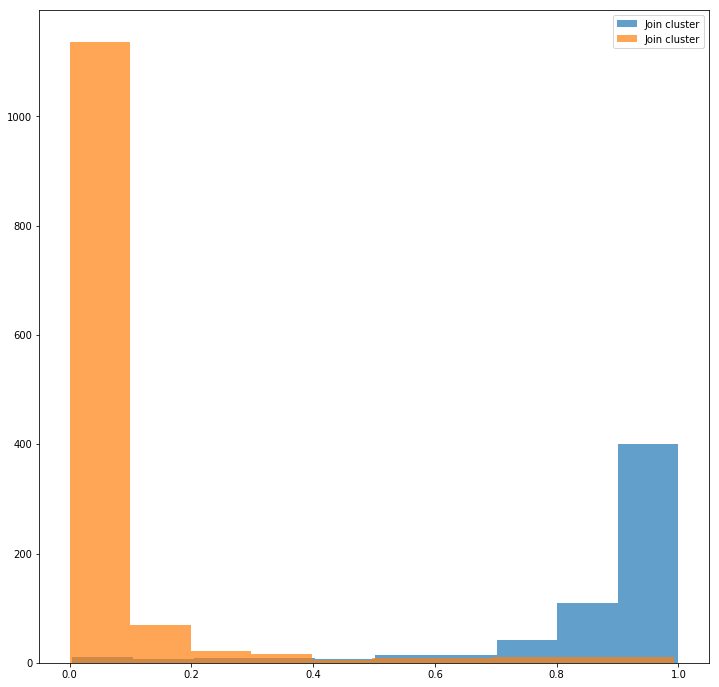

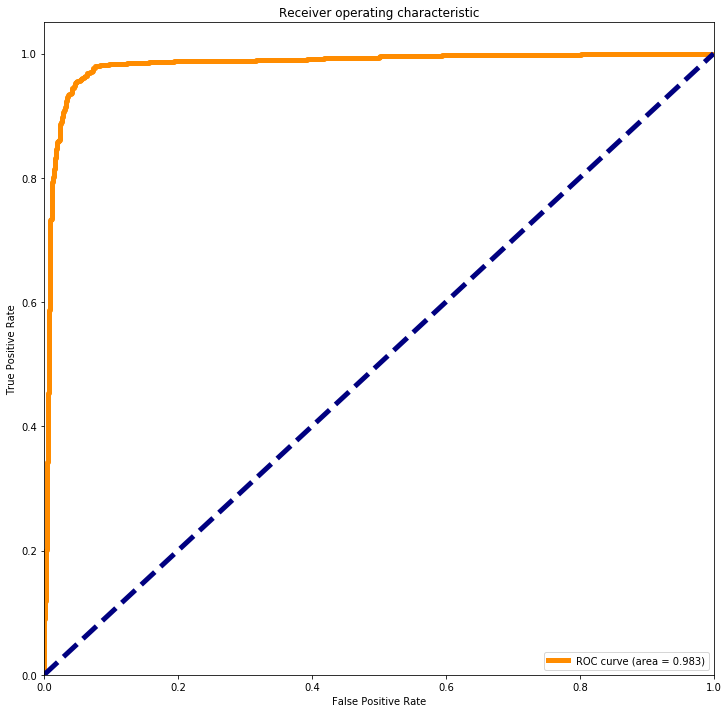

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score

plt.figure(figsize=(12, 12))
predictions = clf.predict_proba(X)[:, 1]
plt.hist(predictions[y==1], label='Join cluster', alpha=0.7)
plt.hist(predictions[y==0], label='Divide cluster', alpha=0.7)
plt.legend()
plt.show()


fpr, tpr, _ = roc_curve(y, predictions)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(12, 12))
lw = 5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
import operator
from collections import Counter
def make_it_trained(root, graphx):
    print('done')
    for child in root:
        make_it_trained(child, graphx)
    if root.is_cluster and root.children:
        Xy = get_train_data(root, graphx)
        X = Xy[0]
        X.append(X[-1] + X[-2] - X[-3])
        root.X = X
        
def run_hdbscan_clf(G, clf, cl_size=20, order=True):
    ####### core_d was deleted => could be returned. Laverage robustness / cluster shaprness.
    edges = []
    for node_id_left, node_id_right, edge in G.edges(data=True):
        node_left = G.node[node_id_left]
        node_right = G.node[node_id_right]
        edges.append(
            (
            node_id_left, node_id_right, edge['weight'], np.sign(node_left['features']['SZ'] - node_right['features']['SZ'])
            )
        )

    #nx.mini
    #edges = list(G.edges(data=True))
    #edges = [(edge[0], # 0
    #          edge[1], # 1
    #          edge[2]['weight'], # 2
    #         ) for edge in edges]
    
    edges = sorted(edges, key = operator.itemgetter(2))

    ### Minimum spanning tree was also thrown
    ### following algo reminds of Kruskal algo but with some modifications

    ### TODO: sort on some mix(i.e. linear) of Z_coord and integrated distance
    
    # init
    clusters = {}
    for node_id in G.nodes():
        clusters[node_id]=ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id])


    for i, j, weight, *_ in edges:
        cluster_out = clusters[i]
        cluster_in = clusters[j]

        ### tunable parameter
        #if cluster_in.nodes_in[j] > 1:
        #    continue

        if cluster_in is cluster_out:
            continue

        if cluster_in.is_cluster and cluster_out.is_cluster:
            cluster = ClusterHDBSCAN(weight=weight , cl_size=cl_size, clusters=[cluster_in, cluster_out])
        elif cluster_in.is_cluster and not cluster_out.is_cluster:
            cluster = cluster_in.append(weight=weight, clusters=[cluster_out])
        elif cluster_out.is_cluster and not cluster_in.is_cluster:
            cluster = cluster_out.append(weight=weight, clusters=[cluster_in])
        else:
            cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=[cluster_in, cluster_out])

        cluster.nodes_out[i] += 1
        cluster.nodes_in[j] += 1

        clusters.update({l: cluster for l in cluster.nodes})
        
    clusters = list(set(clusters.values()))

    ### choose biggest cluster
    root = clusters[0]
    length = len(clusters[0])
    for cluster in clusters:
        if len(cluster) > length:
            length = len(cluster)
            root = cluster
    
    calc_stabilities(root)
    make_it_trained(root, G.subgraph(root.nodes))
    recalc_tree_clf(root, clf)
    clusters = list(leaf_clusters(root))
    return clusters, root

TH = 0.8

def recalc_tree_clf(root, clf):
    weights_children = 0
    #try:
    if root.children and root.is_cluster:
        p = clf.predict_proba([root.X])[0][1]
    else:
        p = 1.
    for child in root:
        recalc_tree_clf(child, clf)
    if p > TH:
        root.children.clear()
    return root

def run_hdbscan_on_brick_clf(graphx, clf, min_cl=40, cl_size=40, order=True):
    connected_components = []
    for cnn in nx.connected_components(nx.Graph(graphx)):
        if len(cnn) > min_cl:
            connected_components.append(nx.DiGraph(graphx.subgraph(cnn)))
    clusters = []
    roots = []
    for G in connected_components:
        if len(G) < 100:
            clusters.append(G)
        else:
            clusters_hdbscan, root_hdbscan = run_hdbscan_clf(G, clf, cl_size=cl_size, order=order)
            roots.append(root_hdbscan)
            clusters.extend(clusters_hdbscan)
    clusters_graphx = []
    for cluster in clusters:
        clusters_graphx.append(
            nx.DiGraph(graphx.subgraph(cluster.nodes))
        )
    return graphx, clusters, roots, clusters_graphx

In [ ]:
TH = 0.7

from IPython.display import clear_output
clusterized_bricks = []
for graphx in tqdm(bricks[len(bricks) // 4:]):
    run_gen_graphx(graphx, layers=5, threshold=400)
    k_nearest_cut_succ(graphx, 25)
    k_nearest_cut_pred(graphx, 25)
    graphx, clusters, roots, clusters_graphx = run_hdbscan_on_brick_clf(graphx=graphx, clf=clf, min_cl=40, cl_size=40)
    clusterized_bricks.append(
        {
            'graphx': graphx,
            'clusters': clusters_graphx,
        }
    )
    clear_output()


 43%|████▎     | 13/30 [6:30:56<8:31:14, 1804.38s/it]

  0%|          | 0/103912 [00:00<?, ?it/s]

  0%|          | 30/103912 [00:00<05:59, 289.29it/s]

  0%|          | 47/103912 [00:00<07:37, 226.88it/s]

  0%|          | 59/103912 [00:00<09:47, 176.75it/s]

  0%|          | 70/103912 [00:00<10:58, 157.65it/s]

  0%|          | 81/103912 [00:00<11:53, 145.43it/s]

  0%|          | 92/103912 [00:00<12:53, 134.14it/s]

  0%|          | 102/103912 [00:00<14:00, 123.51it/s]

  0%|          | 111/103912 [00:00<14:44, 117.42it/s]

  0%|          | 120/103912 [00:01<15:27, 111.91it/s]

  0%|          | 129/103912 [00:01<16:09, 107.03it/s]

  0%|          | 137/103912 [00:01<18:19, 94.39it/s] 

  0%|          | 144/103912 [00:01<19:54, 86.90it/s]

  0%|          | 150/103912 [00:01<20:15, 85.40it/s]

  0%|          | 156/103912 [00:01<20:53, 82.76it/s]

  0%|          | 162/103912 [00:01<21:18, 81.12it/s]

  0%|          | 169/103912 [00:02<21:35, 80.11it/s]

  0%|          | 176/103912 [00

  2%|▏         | 2084/103912 [00:33<27:15, 62.26it/s]

  2%|▏         | 2091/103912 [00:33<27:15, 62.25it/s]

  2%|▏         | 2098/103912 [00:33<27:19, 62.10it/s]

  2%|▏         | 2105/103912 [00:33<27:18, 62.12it/s]

  2%|▏         | 2111/103912 [00:34<27:19, 62.09it/s]

  2%|▏         | 2118/103912 [00:34<27:19, 62.08it/s]

  2%|▏         | 2125/103912 [00:34<27:19, 62.09it/s]

  2%|▏         | 2132/103912 [00:34<27:18, 62.11it/s]

  2%|▏         | 2140/103912 [00:34<27:17, 62.15it/s]

  2%|▏         | 2148/103912 [00:34<27:16, 62.19it/s]

  2%|▏         | 2156/103912 [00:34<27:15, 62.22it/s]

  2%|▏         | 2164/103912 [00:34<27:14, 62.26it/s]

  2%|▏         | 2172/103912 [00:34<27:13, 62.28it/s]

  2%|▏         | 2180/103912 [00:34<27:12, 62.31it/s]

  2%|▏         | 2188/103912 [00:35<27:13, 62.28it/s]

  2%|▏         | 2195/103912 [00:35<27:13, 62.26it/s]

  2%|▏         | 2202/103912 [00:35<27:13, 62.27it/s]

  2%|▏         | 2212/103912 [00:35<27:10, 62.37it/s]

  2%|▏    

  5%|▍         | 4763/103912 [01:06<22:58, 71.95it/s]

  5%|▍         | 4772/103912 [01:06<22:57, 71.95it/s]

  5%|▍         | 4780/103912 [01:06<22:57, 71.95it/s]

  5%|▍         | 4788/103912 [01:06<22:57, 71.94it/s]

  5%|▍         | 4796/103912 [01:06<22:58, 71.92it/s]

  5%|▍         | 4803/103912 [01:06<22:58, 71.89it/s]

  5%|▍         | 4810/103912 [01:06<22:58, 71.87it/s]

  5%|▍         | 4817/103912 [01:07<22:59, 71.84it/s]

  5%|▍         | 4824/103912 [01:07<22:59, 71.83it/s]

  5%|▍         | 4832/103912 [01:07<22:59, 71.83it/s]

  5%|▍         | 4839/103912 [01:07<22:59, 71.83it/s]

  5%|▍         | 4846/103912 [01:07<22:59, 71.82it/s]

  5%|▍         | 4854/103912 [01:07<22:59, 71.82it/s]

  5%|▍         | 4861/103912 [01:07<22:59, 71.81it/s]

  5%|▍         | 4868/103912 [01:07<22:59, 71.81it/s]

  5%|▍         | 4875/103912 [01:07<22:59, 71.80it/s]

  5%|▍         | 4882/103912 [01:08<22:59, 71.79it/s]

  5%|▍         | 4889/103912 [01:08<22:59, 71.78it/s]

  5%|▍    

  7%|▋         | 7223/103912 [01:37<21:46, 74.01it/s]

  7%|▋         | 7244/103912 [01:37<21:44, 74.13it/s]

  7%|▋         | 7264/103912 [01:37<21:42, 74.19it/s]

  7%|▋         | 7281/103912 [01:38<21:41, 74.26it/s]

  7%|▋         | 7297/103912 [01:38<21:39, 74.33it/s]

  7%|▋         | 7312/103912 [01:38<21:38, 74.40it/s]

  7%|▋         | 7327/103912 [01:38<21:37, 74.44it/s]

  7%|▋         | 7341/103912 [01:38<21:36, 74.48it/s]

  7%|▋         | 7354/103912 [01:38<21:35, 74.51it/s]

  7%|▋         | 7369/103912 [01:38<21:34, 74.58it/s]

  7%|▋         | 7382/103912 [01:39<21:34, 74.55it/s]

  7%|▋         | 7393/103912 [01:39<21:34, 74.55it/s]

  7%|▋         | 7403/103912 [01:39<21:34, 74.53it/s]

  7%|▋         | 7413/103912 [01:39<21:34, 74.56it/s]

  7%|▋         | 7422/103912 [01:39<21:33, 74.57it/s]

  7%|▋         | 7431/103912 [01:39<21:33, 74.58it/s]

  7%|▋         | 7440/103912 [01:39<21:33, 74.60it/s]

  7%|▋         | 7449/103912 [01:39<21:32, 74.61it/s]

  7%|▋    

  9%|▉         | 9549/103912 [02:08<21:11, 74.21it/s]

  9%|▉         | 9560/103912 [02:08<21:10, 74.24it/s]

  9%|▉         | 9570/103912 [02:08<21:10, 74.26it/s]

  9%|▉         | 9580/103912 [02:08<21:10, 74.27it/s]

  9%|▉         | 9590/103912 [02:09<21:09, 74.29it/s]

  9%|▉         | 9600/103912 [02:09<21:09, 74.30it/s]

  9%|▉         | 9610/103912 [02:09<21:08, 74.32it/s]

  9%|▉         | 9620/103912 [02:09<21:08, 74.34it/s]

  9%|▉         | 9630/103912 [02:09<21:08, 74.35it/s]

  9%|▉         | 9640/103912 [02:09<21:07, 74.36it/s]

  9%|▉         | 9650/103912 [02:09<21:07, 74.36it/s]

  9%|▉         | 9659/103912 [02:09<21:07, 74.37it/s]

  9%|▉         | 9668/103912 [02:09<21:07, 74.37it/s]

  9%|▉         | 9677/103912 [02:10<21:07, 74.38it/s]

  9%|▉         | 9686/103912 [02:10<21:06, 74.38it/s]

  9%|▉         | 9696/103912 [02:10<21:06, 74.39it/s]

  9%|▉         | 9708/103912 [02:10<21:05, 74.43it/s]

  9%|▉         | 9718/103912 [02:10<21:05, 74.42it/s]

  9%|▉    

 11%|█         | 11673/103912 [02:40<21:07, 72.76it/s]

 11%|█         | 11680/103912 [02:40<21:07, 72.74it/s]

 11%|█         | 11687/103912 [02:40<21:08, 72.73it/s]

 11%|█▏        | 11694/103912 [02:40<21:08, 72.71it/s]

 11%|█▏        | 11700/103912 [02:40<21:08, 72.70it/s]

 11%|█▏        | 11706/103912 [02:41<21:08, 72.68it/s]

 11%|█▏        | 11712/103912 [02:41<21:08, 72.67it/s]

 11%|█▏        | 11718/103912 [02:41<21:08, 72.66it/s]

 11%|█▏        | 11724/103912 [02:41<21:09, 72.64it/s]

 11%|█▏        | 11730/103912 [02:41<21:09, 72.63it/s]

 11%|█▏        | 11736/103912 [02:41<21:09, 72.62it/s]

 11%|█▏        | 11742/103912 [02:41<21:09, 72.60it/s]

 11%|█▏        | 11749/103912 [02:41<21:09, 72.59it/s]

 11%|█▏        | 11756/103912 [02:41<21:09, 72.59it/s]

 11%|█▏        | 11766/103912 [02:42<21:09, 72.61it/s]

 11%|█▏        | 11774/103912 [02:42<21:09, 72.60it/s]

 11%|█▏        | 11781/103912 [02:42<21:09, 72.60it/s]

 11%|█▏        | 11788/103912 [02:42<21:09, 72.5

In [42]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

297
[(0, 297)]
113
[(1, 113)]
483
[(2, 483)]
106
[(3, 106)]
91
[(4, 91)]
647
[(5, 548), (19, 99)]
299
[(6, 299)]
55
[(7, 55)]
232
[(8, 232)]
123
[(9, 123)]
45
[(10, 45)]
526
[(11, 526)]
513
[(12, 513)]
116
[(13, 116)]
1458
[(14, 1458)]
899
[(15, 899)]
108
[(16, 108)]
852
[(17, 852)]
253
[(18, 253)]


In [39]:
len(clusterized_bricks[0]['clusters'])

18

In [40]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

297
[(0, 297)]
113
[(1, 113)]
483
[(2, 483)]
106
[(3, 106)]
91
[(4, 91)]
647
[(5, 548), (19, 99)]
299
[(6, 299)]
55
[(7, 55)]
232
[(8, 232)]
123
[(9, 123)]
526
[(11, 526)]
513
[(12, 513)]
116
[(13, 116)]
1458
[(14, 1458)]
899
[(15, 899)]
108
[(16, 108)]
852
[(17, 852)]
253
[(18, 253)]


In [36]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

297
[(0, 297)]
116
[(1, 116)]
486
[(2, 486)]
114
[(3, 114)]
91
[(4, 91)]
649
[(5, 550), (19, 99)]
319
[(6, 319)]
55
[(7, 55)]
232
[(8, 232)]
123
[(9, 123)]
58
[(10, 58)]
534
[(11, 534)]
513
[(12, 513)]
116
[(13, 116)]
1464
[(14, 1464)]
903
[(15, 903)]
113
[(16, 113)]
855
[(17, 855)]
261
[(18, 261)]


In [33]:
6 500
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

301
[(0, 301)]
119
[(1, 119)]
491
[(2, 491)]
114
[(3, 114)]
92
[(4, 92)]
676
[(5, 575), (19, 101)]
348
[(6, 348)]
55
[(7, 55)]
234
[(8, 234)]
125
[(9, 125)]
61
[(10, 61)]
539
[(11, 539)]
529
[(12, 529)]
124
[(13, 124)]
1472
[(14, 1472)]
914
[(15, 914)]
115
[(16, 115)]
861
[(17, 861)]
270
[(18, 270)]


In [30]:
for k in range(len(clusterized_bricks[0]['clusters'])):
    print(len(clusterized_bricks[0]['clusters'][k]))
    print(class_disbalance_graphx(clusterized_bricks[0]['clusters'][k]))

301
[(0, 301)]
119
[(1, 119)]
491
[(2, 491)]
114
[(3, 114)]
92
[(4, 92)]
676
[(5, 575), (19, 101)]
348
[(6, 348)]
55
[(7, 55)]
234
[(8, 234)]
125
[(9, 125)]
61
[(10, 61)]
540
[(11, 540)]
529
[(12, 529)]
124
[(13, 124)]
1472
[(14, 1472)]
914
[(15, 914)]
115
[(16, 115)]
861
[(17, 861)]
270
[(18, 270)]


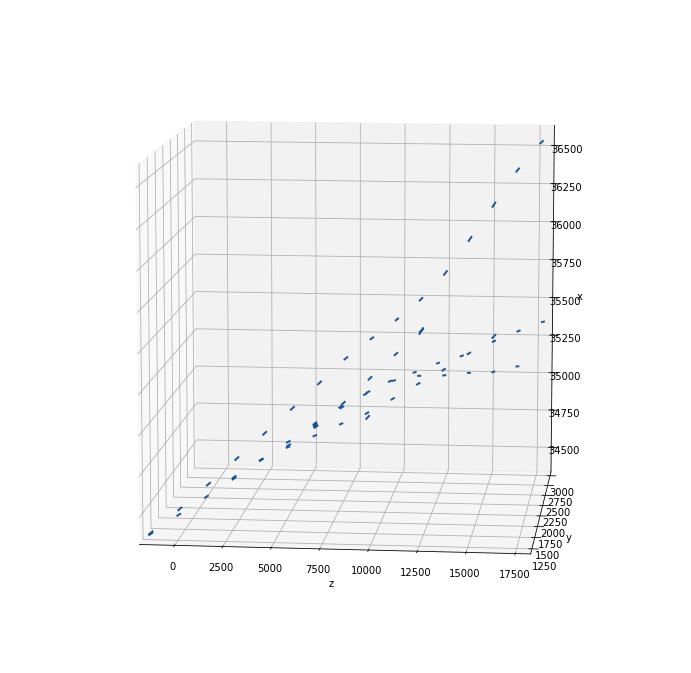

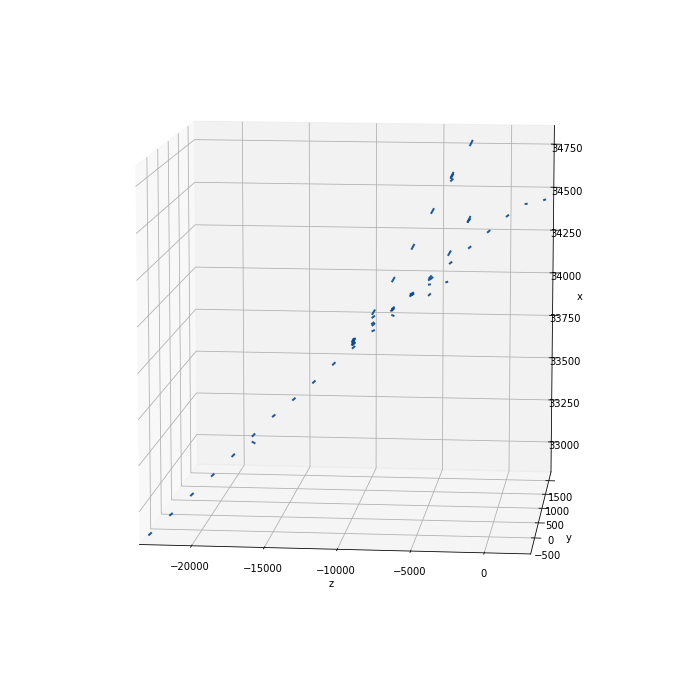

In [95]:
plot_graphx((clusterized_bricks[0]['clusters'][9]))
plot_graphx((clusterized_bricks[0]['clusters'][10]))

In [32]:
NUM_SHOWERS_IN_BRICK

200


 16%|█▌        | 17150/110170 [05:20<28:57, 53.53it/s]

In [33]:
len(clusterized_bricks)

18

In [34]:
with open('../data/opera/clusterized_bricks_{}.pickle'.format(NUM_SHOWERS_IN_BRICK), 'wb') as f:
    pickle.dump(clusterized_bricks, f, protocol=pickle.HIGHEST_PROTOCOL)